In [ ]:
 import math

class Value:
  def __init__(self,data,_children=(),_op="",label=""):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data + other.data,(self,other),"+")
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward
    return out

  def __mul__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data * other.data, [self,other],"*")

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward

    return out

  def __pow__(self,other):
    assert isinstance(other,(int,float)), "only int/float supported"
    out = Value(self.data ** other,(self,),f'**{other}')

    def _backward():
      self.grad += other * self.data ** (other - 1)

    out._backward = _backward
    return out

  def __rmul__(self,other):
    return self * other

  def __truediv__(self,other):
    return self * other ** -1

  def __neg__(self):
    return self * -1

  def __sub__(self,other):
    return self + (-other)

  def __raddd__(self,other):
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t,(self,),"tanh")

    def _backward():
      self.grad +=  1 - (t ** 2) * out.grad

    out._backward = _backward
    return out

  def exp(self):
    x =  self.data
    out = Value(math.exp(x),(self,),"exp")

    def _backward():
      self.grad += math.exp(x) * out.grad

    out._backward = _backward
    return out

  def backward(self):

    topo = []
    visited = set()

    def sort(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          sort(child)
        topo.append(v)

    sort(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()









In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

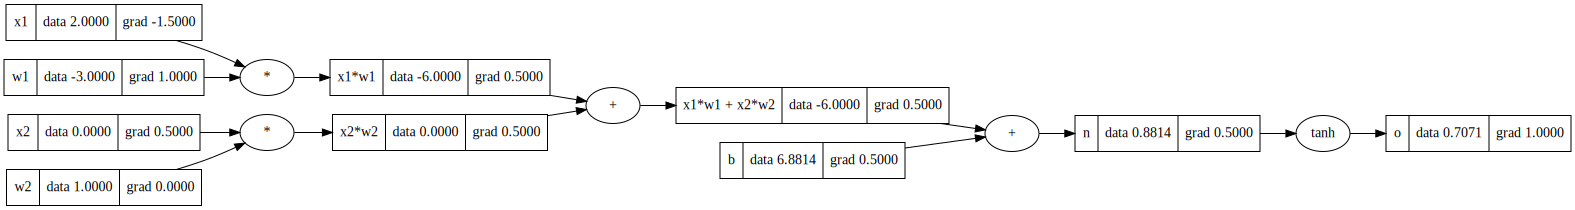

In [ ]:
draw_dot(o)

In [ ]:
import random

class Neuron:
  def __init__(self,numInputs):
    self.w = [Value(random.uniform(-1,1) for i in range(numInputs))]
    self.b = Value(random.uniform(-1,1))

  def __call__(self,x):
    act = sum( (wi * xi for wi, xi in zip(self.w,x)),self.b)
    out = act.tanh()
    return out

  def parameter(self):
    return self.w + [self.b]


class Layer:
  def __init__(self,numInputs,numLayers):
    self.neurons = [Neuron(numInputs) for _ in range(numLayers)]

  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameter(self):
    return [p for neuron in self.neurons for p in neuron.parameter()]

class MLP:
  def __init__(self,numInputs,numOutputLayers):
    sz = [numInputs] + numOutputLayers
    self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(numOutputLayers))]

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameter(self):
    return [p for layer in self.layers for p in layer.parameter()]

In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

TypeError: unsupported operand type(s) for *: 'generator' and 'float'